# Speech emotion Classification

## Problem Statement

#### Given audio (wav) files identify the emotion associated to it.

## Dataset
### Dataset is acquired from https://github.com/SenticNet/MELD. It is a multimodal dataset, but we have used only audio data for this task

## Approach and Results

### In this notebook I have used 3 DL architectures. MLP, 1D- CNN and 2D CNN and achieved accuracy of 62.29%, 62.29% and 62.15% respectively on validation dataset 

## Features used

### For 1-D CNN and MLP I have used four features with combined length of 193. These features are mfcc, chroma,mel,contrast and tonnetz. For 2D CNN I have extracted 2D MFCC matrix

## Possible further improvements:

    Since MELD is a multimodal dataset we can use text features from the subtitles file and this is expected to give a good increase in accuracy
    
    Dataset is highly class imbalanced so we will try to eliminate some data from classes that contain considerably more audio files
    
    Hyperparameter tuning in the algorithms.
    
    
    
    

## Imports

In [1]:
import scipy
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

import librosa
import librosa.display

import IPython.display as ipd




In [2]:
train_dir = './train'
test_dir = './val'
current_dir = os.getcwd()

## Helper functions

In [3]:

# Print all the classes of emotions in dataset
labels = []
for files in os.listdir(train_dir):
    f = files.split()[-1].split('\\')[-1]
    labels.append(f.strip())
    
print (labels)

def audio_len(filename):
    '''Return length of the audio file in seconds'''
    samples,sample_rates = librosa.load(filename)
    #print (sample_rates)
    return (len(samples)/sample_rates)
    
import struct
def read_file_properties(filename):
    
    wave_file = open(filename,"rb")
    riff = wave_file.read(12)
    fmt = wave_file.read(36)
    num_channels_string = fmt[10:12]
    num_channels = struct.unpack('<H', num_channels_string)[0]
    sample_rate_string = fmt[12:16]
    sample_rate = struct.unpack("<I",sample_rate_string)[0]    
    bit_depth_string = fmt[22:24]
    bit_depth = struct.unpack("<H",bit_depth_string)[0]
    return (num_channels, sample_rate, bit_depth)

    

['disgust', 'fear', 'happy', 'neutral', 'sad']


In [4]:
#Testing our helper functions

print(audio_len('./train\\fear\\MEL_dia1025_utt11_negative_FEA.wav'))
print(read_file_properties('./train\\fear\\MEL_dia1025_utt11_negative_FEA.wav'))

7.317324263038548
(2, 16000, 16)


## Creating a metadata file for our Training Dataset

In [ ]:
train_metadata=[]

for label in labels:
    files=os.listdir("train/"+label)
    
    for f in files:
        #print (f)
        file_name="train/"+label+"/"+f
        print (file_name)
        data = read_file_properties(file_name)
        length=audio_len(file_name)
        #print (data[0])
        train_metadata.append([file_name, label, data[0], data[1], data[2], length])
        
train_metadata_df = pd.DataFrame(train_metadata, columns=['filename','class_label', 'Channels', 'Sample_Rate', 'Bit_Depth','Length'])
print("finished")

In [6]:
print (train_metadata_df.describe())
train_metadata_df.to_csv('train_metadata.csv')

       Channels  Sample_Rate  Bit_Depth       Length
count    7354.0       7354.0     7354.0  7354.000000
mean        2.0      16000.0       16.0     3.206995
std         0.0          0.0        0.0     3.641048
min         2.0      16000.0       16.0     0.064036
25%         2.0      16000.0       16.0     1.600000
50%         2.0      16000.0       16.0     2.474694
75%         2.0      16000.0       16.0     4.010703
max         2.0      16000.0       16.0   235.072018


## Creating a metadata file for our Validation Dataset

In [ ]:
test_metadata=[]

for label in labels:
    files=os.listdir("val/"+label)
    
    for f in files:
        #print (f)
        file_name="val/"+label+"/"+f
        print (file_name)
        data = read_file_properties(file_name)
        length=audio_len(file_name)
        test_metadata.append([file_name, label, data[0], data[1], data[2], length])
    
test_metadata_df = pd.DataFrame(test_metadata, columns=['filename','class_label', 'Channels', 'Sample_Rate', 'Bit_Depth','Length'])
print("finished")    
test_metadata_df.to_csv('test_metadata.csv')

## Exploring Training Dataset

In [8]:
# Number of Unique values in columns of dataset
for col in train_metadata_df.columns:
    print (train_metadata_df[col].nunique(),col)

7354 filename
5 class_label
1 Channels
1 Sample_Rate
1 Bit_Depth
437 Length


In [9]:
# printing number of audio files for each category

print(train_metadata_df.class_label.value_counts())

# here we can see our data is highly class imbalanced

neutral    4592
happy      1609
sad         705
disgust     232
fear        216
Name: class_label, dtype: int64


count    7354.000000
mean        3.206995
std         3.641048
min         0.064036
25%         1.600000
50%         2.474694
75%         4.010703
max       235.072018
Name: Length, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002924C794048>]],
      dtype=object)

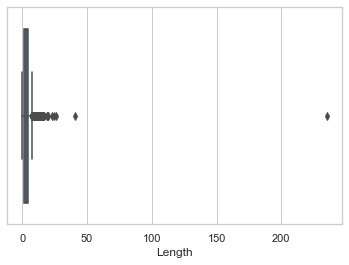

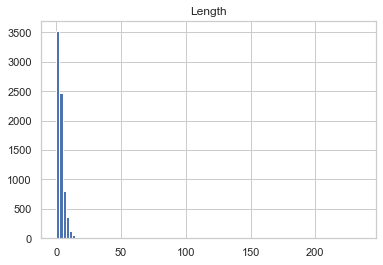

In [10]:
# Since number of channels, sample rate and bit depth is same for all the features we will focus on length of the audio files

import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(x=train_metadata_df['Length'])

print(train_metadata_df['Length'].describe())
train_metadata_df.hist(column=['Length'],bins=100)



# here we can say files with length greater than 100 can be considered outlier

In [11]:
# Seeing lengths of the audio files wrt to different classes
df_train_fear= train_metadata_df[train_metadata_df['class_label']=='fear']
df_train_happy= train_metadata_df[train_metadata_df['class_label']=='happy']
df_train_disgust= train_metadata_df[train_metadata_df['class_label']=='disgust']
df_train_neutral= train_metadata_df[train_metadata_df['class_label']=='neutral']
df_train_sad= train_metadata_df[train_metadata_df['class_label']=='sad']


In [12]:
#Analysing audio lengths
print (df_train_fear['Length'].describe())
print ('#'*100)
print (df_train_happy['Length'].describe())
print ('#'*100)
print (df_train_disgust['Length'].describe())
print ('#'*100)
print (df_train_neutral['Length'].describe())
print ('#'*100)
print (df_train_sad['Length'].describe())

# We can see high std deviation for length in'disgust' label

count    216.000000
mean       3.454046
std        2.360168
min        0.128027
25%        1.877324
50%        2.709365
75%        4.362687
max       12.928027
Name: Length, dtype: float64
####################################################################################################
count    1609.000000
mean        3.287900
std         2.783424
min         0.064036
25%         1.557324
50%         2.517324
75%         4.053333
max        41.045351
Name: Length, dtype: float64
####################################################################################################
count    232.000000
mean       4.700803
std       15.432380
min        0.256009
25%        1.914683
50%        2.922721
75%        5.056009
max      235.072018
Name: Length, dtype: float64
####################################################################################################
count    4592.000000
mean        3.007515
std         2.254680
min         0.064036
25%         1.514694
50%         2.368

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002924C8CB5C8>]],
      dtype=object)

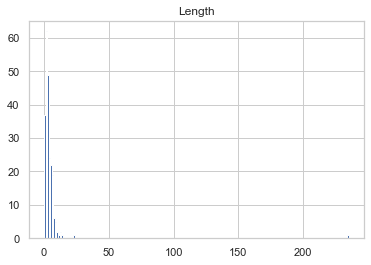

In [13]:
df_train_disgust.hist(column=['Length'],bins=200)

# we can say disgust is the label with more outliers

In [14]:
df_test_disgust= test_metadata_df[test_metadata_df['class_label']=='disgust']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002924C902B08>]],
      dtype=object)

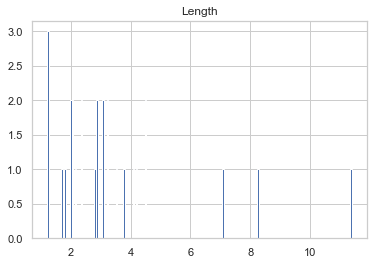

In [15]:
df_test_disgust.hist(column=['Length'],bins=200)
# since none of the audio file length lies in outlier region we can remove the outliers from our train dataset

## Removing outliers

In [16]:
train_metadata_df_new = train_metadata_df[train_metadata_df['Length']<15]
train_metadata_df_new.shape

(7337, 6)

## Features visualisation

In [17]:
def waveplot(filename):
    librosa_audio, librosa_sample_rate = librosa.load(filename)
    plt.figure(figsize=(12, 4))
    plt.plot(librosa_audio)


def spectrogram(input_sample):
    freqs, time, spectrogram = signal.spectrogram(input_sample)
    spec = np.log(spectrogram.T.astype('float32')) #converting into logarithmic scale for better visualization
    return plt.imshow(spec.T, extent = [time.min(), time.max(), freqs.min(), freqs.max()], origin = 'lower', aspect = 'auto')

def MEL_POWER_SPEC(sample, sample_rate):
    mfcc = librosa.feature.melspectrogram(np.float32(sample), sr=sample_rate, n_mels=100)
    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_scale = librosa.power_to_db(mfcc, ref=np.max)
    return librosa.display.specshow(log_scale, sr=sample_rate, x_axis='time', y_axis='mel')

def MFCC(MEL_POWER_SPEC):
    #super(MFCC).__init__()
    mfcc1 = librosa.feature.mfcc(MEL_POWER_SPEC.log_scale, n_mfcc=13)
    # Let's pad on the first and second deltas while we're at it
    delta2_mfcc = librosa.feature.delta(mfcc1, order=2)    
    return librosa.display.specshow(delta2_mfcc)

## Waveplots

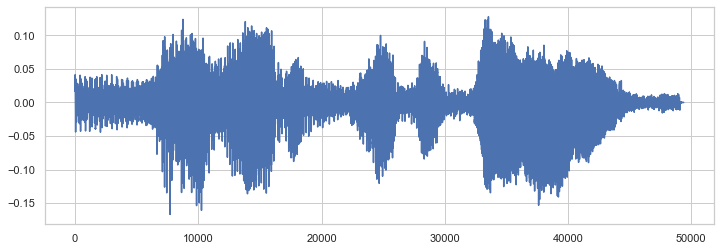

In [18]:
# for happy
waveplot('val/happy/MEL_dia46_utt1_negative_HAP.wav')

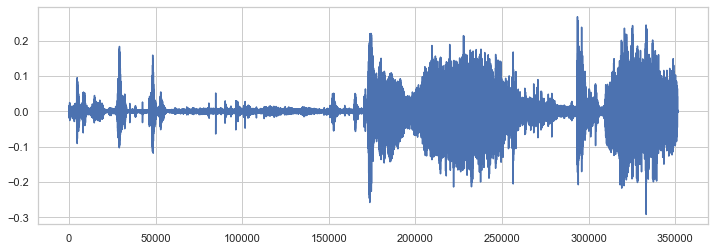

In [19]:
# for sad
waveplot('val/sad/MEL_dia84_utt4_negative_SAD.wav')


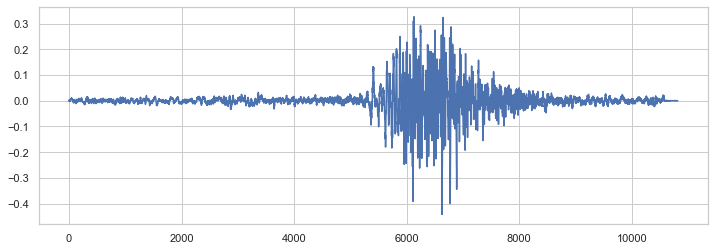

In [20]:
# for neutral
waveplot('val/neutral/MEL_dia62_utt5_positive_NEU.wav')


## Spectograms

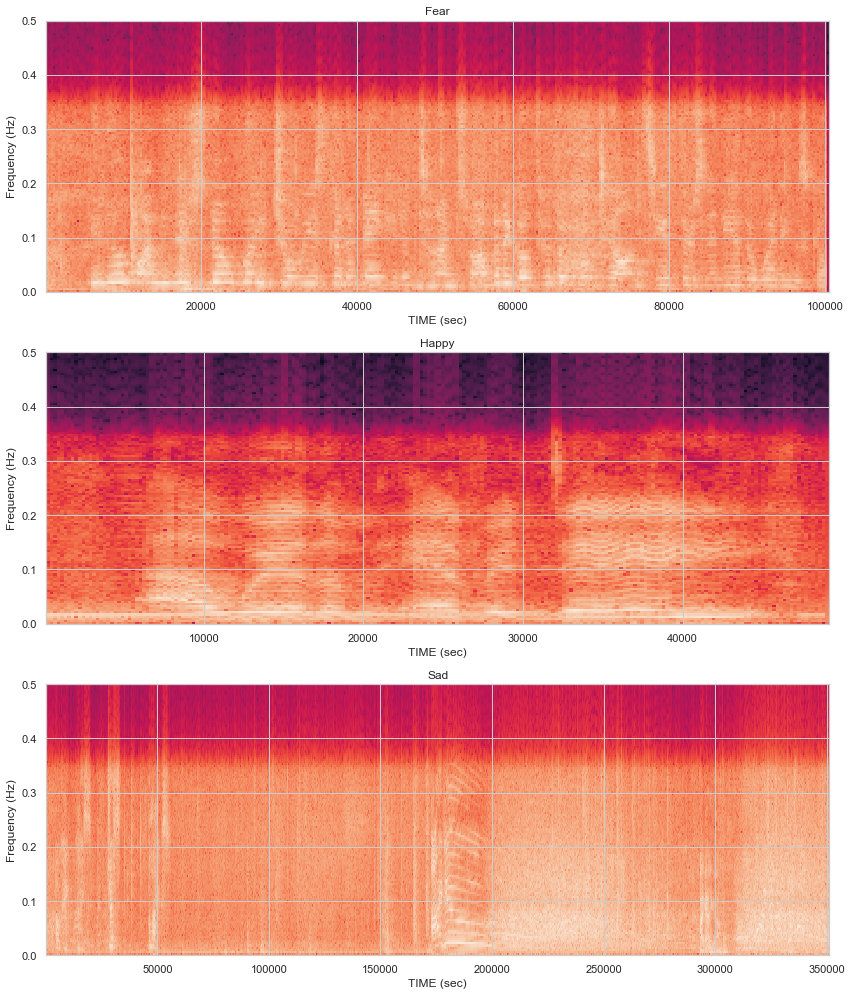

In [21]:
samples1, sample_rates1 = librosa.load('val/fear/MEL_dia11_utt1_negative_FEA.wav')
samples2, sample_rates2 = librosa.load('val/happy/MEL_dia46_utt1_negative_HAP.wav')
samples3, sample_rates3 = librosa.load('val/sad/MEL_dia84_utt4_negative_SAD.wav')


plt.figure(figsize = (12,14))
plt.subplot(3, 1, 1)
spectrogram(samples1)
plt.title('Fear')
plt.xlabel('TIME (sec)')
plt.ylabel('Frequency (Hz)')

plt.subplot(3, 1, 2)
spectrogram(samples2)
plt.title('Happy')
plt.xlabel('TIME (sec)')
plt.ylabel('Frequency (Hz)')

plt.subplot(3, 1, 3)
spectrogram(samples3)
plt.title('Sad')
plt.xlabel('TIME (sec)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()

## Mel Power Spectogram

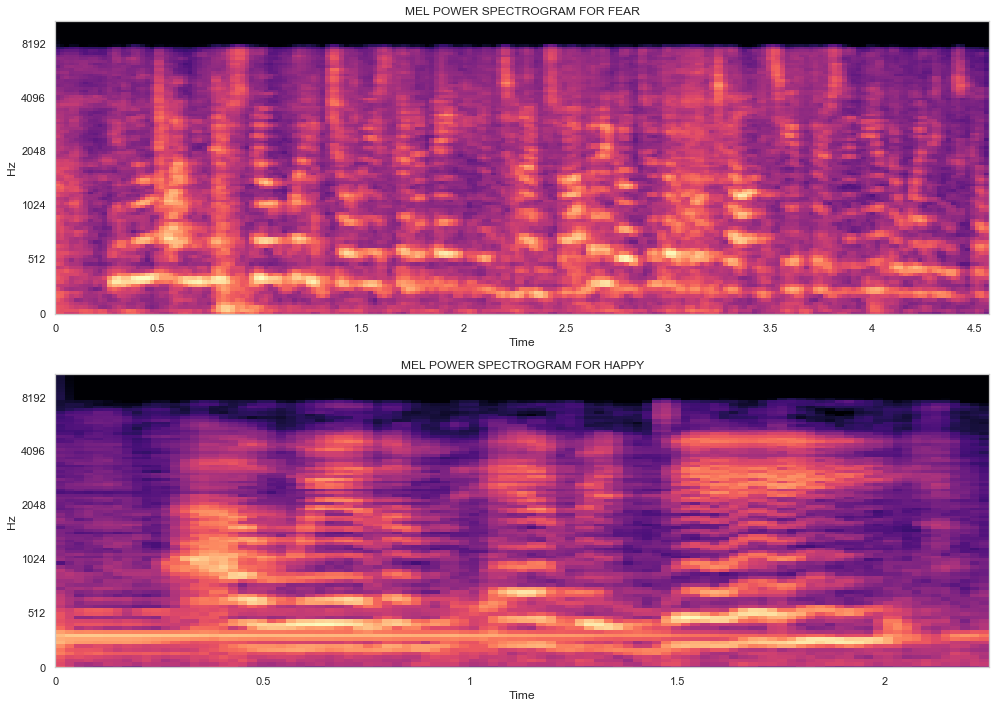

In [22]:

plt.figure(figsize = (14,10))

plt.subplot(2, 1, 1)
MEL_POWER_SPEC(samples1, sample_rates1)
#MFCC(MEL_POWER_SPEC)
plt.title('MEL POWER SPECTROGRAM FOR FEAR')

plt.subplot(2, 1, 2)
MEL_POWER_SPEC(samples2, sample_rates2)
#MFCC(MEL_POWER_SPEC)
plt.title('MEL POWER SPECTROGRAM FOR HAPPY')

# plt.subplot(3, 1, 3)
# MFCC(samples6, sample_rates6)
# plt.title('BIRD')

plt.tight_layout()
# plt.show()

# Model Building (Simple neural network)

In [23]:
def extract_features_mfcc(file_name):
    ''' Extract mfcc, chroma,mel,contrast and tonnetz features from the audio and return it'''
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs.tolist(),chroma.tolist(),mel.tolist(),contrast.tolist(),tonnetz.tolist()

In [ ]:
print (labels)

files = train_metadata_df_new['filename']


features_nn = []
print (files.shape)

for f in files:
    file_name=f
    print (file_name)
    data_dim = extract_features_mfcc(file_name)
    data=(data_dim[0]+data_dim[1]+data_dim[2]+data_dim[3]+data_dim[4])
    #print (len(data))
    #print (data)
    label_row = train_metadata_df_new.loc[train_metadata_df_new['filename'] == f]
    label=label_row['class_label'].values[0]
    print (label)
    features_nn.append([data, label])


import pandas as pd 
features_nn_df = pd.DataFrame(features_nn, columns=['feature','class_label'])
print("finished")

In [ ]:

files_test = test_metadata_df['filename']


features_nn_test = []
print (files_test.shape)

for f in files_test:
    file_name=f
    print (file_name)
    
    data_dim = extract_features_mfcc(file_name)
    data=(data_dim[0]+data_dim[1]+data_dim[2]+data_dim[3]+data_dim[4])
    
    label_row = test_metadata_df.loc[test_metadata_df['filename'] == f]
    label=label_row['class_label'].values[0]
    print (label)
    features_nn_test.append([data, label])


import pandas as pd 
features_nn_test_df = pd.DataFrame(features_nn_test, columns=['feature','class_label'])
print("finished")

In [26]:
df_train_test = features_nn_df.append(features_nn_test_df)
df_train_test.shape

(8167, 2)

In [64]:
print(df_train_test.shape)
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np

# Convert features and corresponding classification labels into numpy arrays
X = np.array(df_train_test.feature.tolist())
y = np.array(df_train_test.class_label.tolist())

#print (y[2000:2300])

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))
#print (yy[2000:2300])


# disgust = 0, fear = 1, happy = 2, neutral = 3, sad = 4

(8167, 2)


In [67]:

X_train=X[0:7337,: ]
X_test=X[7337:8167,: ]

yy_train=yy[0:7337,: ]
yy_test=yy[7337:8167,: ]

print (X_train.shape)
print (X_test.shape)

print (yy_train.shape)
print (yy_test.shape)

(7337, 193)
(830, 193)
(7337, 5)
(830, 5)


In [68]:
# split the dataset 
from sklearn.model_selection import train_test_split 



x_train, x_test, y_train, y_test = train_test_split(X_train, yy_train, test_size=0.2, random_state = 42)

In [69]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(193,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [70]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               49664     
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_18 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                

In [ ]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 15
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

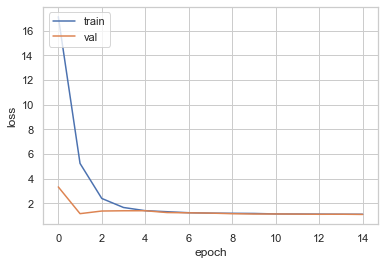

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
Accuracy: 62.29%
Saved model to disk


In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

from sklearn.metrics import accuracy_score
# model predictions
y_pred = model.predict(X_test)
y_pred=(y_pred == y_pred.max(axis=1, keepdims=1)).astype(float)
print (y_pred)
# calculate the accuracy
accuracy = accuracy_score(y_true=yy_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

model.save("saved_models/model_mlp_his.h5")
print("Saved model to disk")

In [75]:
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model, Sequential
import keras
from keras.utils import np_utils
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

model2 = Sequential()

#model = Sequential()
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(193,1)))
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model2.add(Dropout(0.5))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(100, activation='relu'))
model2.add(Dense(5, activation='softmax'))
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6)

In [76]:

model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 191, 64)           256       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 189, 64)           12352     
_________________________________________________________________
dropout_10 (Dropout)         (None, 189, 64)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 94, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6016)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               601700    
_________________________________________________________________
dense_14 (Dense)             (None, 5)                

In [77]:
# model compilation
model2.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [78]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_valcnn= np.expand_dims(X_test, axis=2)
model2_cnn=model2.fit(x_traincnn, yy_train, batch_size=16, epochs=7, validation_data=(x_valcnn, yy_test))

Train on 7337 samples, validate on 830 samples
Epoch 1/7
7337/7337 [==============================] - 9s 1ms/step - loss: 1.5917 - accuracy: 0.4742 - val_loss: 1.1252 - val_accuracy: 0.6217
Epoch 2/7
7337/7337 [==============================] - 9s 1ms/step - loss: 1.2506 - accuracy: 0.5643 - val_loss: 1.0915 - val_accuracy: 0.6217
Epoch 3/7
7337/7337 [==============================] - 9s 1ms/step - loss: 1.1902 - accuracy: 0.5823 - val_loss: 1.0907 - val_accuracy: 0.6217
Epoch 4/7
7337/7337 [==============================] - 8s 1ms/step - loss: 1.1592 - accuracy: 0.5933 - val_loss: 1.0855 - val_accuracy: 0.6229
Epoch 5/7
7337/7337 [==============================] - 8s 1ms/step - loss: 1.1354 - accuracy: 0.6061 - val_loss: 1.0915 - val_accuracy: 0.6229
Epoch 6/7
7337/7337 [==============================] - 8s 1ms/step - loss: 1.1261 - accuracy: 0.6023 - val_loss: 1.0911 - val_accuracy: 0.6229
Epoch 7/7
7337/7337 [==============================] - 8s 1ms/step - loss: 1.1100 - accuracy: 0

In [79]:
# model predictions
x_t =np.expand_dims(X_test, axis=2)
y_pred = model2.predict(x_t)

y_pred=(y_pred == y_pred.max(axis=1, keepdims=1)).astype(float)
print (y_pred)

# calculate the accuracy
accuracy = accuracy_score(y_true=yy_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

model2.save("saved_models/model_cnn.h5")
print("Saved model to disk")

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
Accuracy: 62.29%
Saved model to disk


In [101]:
import numpy as np
max_pad_len = 680

def extract_features_cnn_2D(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        #print (pad_width)
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return 'None' 
     
    return mfccs



In [96]:
extract_features_cnn_2D('train/neutral/MEL_dia241_utt13_negative_NEU.wav')



37


array([[-3.2896170e+02, -3.3907266e+02, -3.7105038e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.0601878e+02,  1.0817923e+02,  1.0808168e+02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.9460182e+01, -2.2479605e+01, -2.4471773e+01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-1.0271881e+00, -1.8640103e+00, -2.6557550e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.7089903e-01, -9.7527492e-01, -4.3168535e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.8677709e+00, -8.2668370e-01, -2.2306778e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [ ]:
files = train_metadata_df_new['filename']


features_cnn2d = []
print (files.shape)

for f in files:
    file_name=f
    print (file_name)
    data = extract_features_cnn_2D(file_name)
    print (data.shape)
    label_row = train_metadata_df_new.loc[train_metadata_df_new['filename'] == f]
    label=label_row['class_label'].values[0]
    print (label)
    features_cnn2d.append([data, label])


features_cnn2d_df_train = pd.DataFrame(features_cnn2d, columns=['feature','class_label'])
print("finished")

In [ ]:
files_test = test_metadata_df['filename']


features_cnn2d_test = []
print (files_test.shape)

for f in files_test:
    file_name=f
    print (file_name)
    
    data = extract_features_cnn_2D(file_name)
    label_row = test_metadata_df.loc[test_metadata_df['filename'] == f]
    label=label_row['class_label'].values[0]
    
    if (data!='None'):
        features_cnn2d_test.append([data, label])


import pandas as pd 
features_cnn2d_df_test = pd.DataFrame(features_cnn2d_test, columns=['feature','class_label'])
print("finished")

In [126]:
df_train_test_cnn2d = features_cnn2d_df_train.append(features_cnn2d_df_test)

print (df_train_test_cnn2d.shape)

nna = np.zeros((8164,40,680))
kk = df_train_test_cnn2d['feature'].values


for i in range(0,8164):
    nna[i]=kk[i]
    
print (nna.shape)

# Convert features and corresponding classification labels into numpy arrays
X = np.array(nna)
y = np.array(df_train_test_cnn2d.class_label.tolist())
y=y[0:8164]

X_train=nna[0:7337,: ]
X_test=nna[7337:8164,: ]



# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

y_train=yy[0:7337]
y_test=yy[7337:8164]


print (X_train.shape,X_test.shape)
print (y_train.shape,y_test.shape)


# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)
print (x_train.shape)

(8164, 2)
(8164, 40, 680)
(7337, 40, 680) (827, 40, 680)
(7337, 5) (827, 5)
(5869, 40, 680)


In [127]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 680
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))


In [128]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')

In [130]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)


from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

#num_epochs = 12
#num_batch_size = 128

num_epochs = 20
num_batch_size = 512

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

cnn2d=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 679, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 339, 16)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 19, 339, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 338, 32)       2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 169, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 9, 169, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 168, 64)      

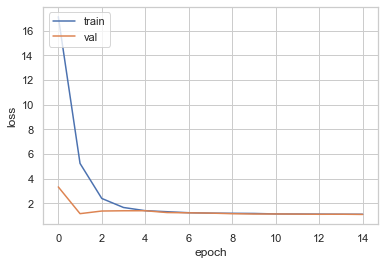

In [131]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [136]:
# model predictions
x_t =np.expand_dims(X_test, axis=3)
y_pred = model.predict(x_t)

y_pred=(y_pred == y_pred.max(axis=1, keepdims=1)).astype(float)
print (y_pred.shape)

# calculate the accuracy
accuracy = accuracy_score(y_true=yy[7337:8164], y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

model.save("saved_models/model_cnn_2d.h5")
print("Saved model to disk")

(827, 5)
Accuracy: 62.15%
Saved model to disk


In [138]:
print (model2.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 191, 64)           256       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 189, 64)           12352     
_________________________________________________________________
dropout_10 (Dropout)         (None, 189, 64)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 94, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6016)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               601700    
_________________________________________________________________
dense_14 (Dense)             (None, 5)                

In [139]:
model2.save("saved_models/model_cnn_1d.h5")
print("Saved model to disk")

Saved model to disk
